# Distribution-based feature extraction from whole-genome data

The following notebook presents the reproducible code for analyzing the quality of automatically extracted classification features from whole-genome VCF files. The code contains comments concerning each step of the analysis that served as the basis for the paper **Distribution-based feature extraction from whole-genome data** by Piernik *et al.*

The analysis was coded with Python 3.7.9. The environment specification is provided in the `requirements.txt` in the root of the GitHub repository (https://github.com/MNMdiagnostics/distribution_based_features). Utility methods used in this analysis can by found in the `experiment_utils.py` file.

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML

# main DBFE module
from dbfe import DistributionBasedFeatureExtractor
# utility methods to make this notebook shorter
from experiment_util import *

The global parameters of the analysis are presented below. We will analyze how distribution based features can be used to classify ovarian, lung, and breast cancer patients. Ovarian cancer patients were labeled as responders/non-responders to platinium-based or poly (ADP-ribose) polymerase inhibitor (PARPi) therapy, lung cancer patients were labeled as responders/non-responders to immutherapy, and breast cancer patients were labeled according to their subtype: HER2+, ER+ HER2-, triple negative breast cancer (TNBC). 

From these samples we extracted three types of copy number variations (CNVs): deletions (DEL), diploids (DIP), duplications (DUP), and three types of structural variants (SVs): inversions (INV), deletions (DEL), tandem duplications (DUP)). Lengths of those CNVs and SVs are treated as input to our distribution-based feature extraction (DBFE) approaches, and then passed to classifiers. In our experiments, we compare how DBFE features affect four  types of classifiers: Random Forest (RF), Naive Bayes (NB), Logistic Regression (LR), k-Nearest Neighbors (kNN).

The datasets will be split into training and testing in proportions 70%, 30%, respectively. Sensitivity tests will be performed only on the training tests, using 2 repetitions of 5-fold cross-validation (2x5 CV). The result files and figures will be saved to the `results` folder.

In [2]:
HOLDOUT_SIZE = 0.3
SEED = 23 # Michael Jordan
CV = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=SEED)
RESULTS_FOLDER = "results"

CANCERS = [('lung', ['RES', 'NONRES']), ('ovarian', ['RES', 'NONRES']), 
           ('breast', ['HER2+', 'ER+ HER2-']), ('breast', ['HER2+', 'TNBC']), ('breast', ['ER+ HER2-', 'TNBC'])]
VARIANTS = [('cnv', 'del'), ('cnv', 'dip'), ('cnv', 'dup'), ('sv', 'inv'), ('sv', 'del'), ('sv', 'dup')]
METHODS = ['quantile', 'clustering', 'supervised']
ALGORITHMS = {
    "RF": RandomForestClassifier(random_state=SEED),
    "NB": GaussianNB(),
    "LR": LogisticRegression(random_state=SEED),
    "kNN": KNeighborsClassifier(),
}
CLUSTER_COLORS = ['#648FFF', '#FFB000', '#DC267F']
SUBTYPE_COLORS = ['#4477aa', '#ee6677', '#228833']
COLOR_MAPPING = {0: '#648FFF', 1: '#FFB000', 2: '#DC267F'}

## Datasets

Experiments were performed on 3 sets of genomic samples for patients with ovarian, breast, or lung cancer, respectively. Samples were taken from [The Cancer Genome Atlas](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga), [Hartwig Medical Foundation](https://www.hartwigmedicalfoundation.nl/en/database/) and the [International Cancer Genome Consortium](https://dcc.icgc.org/) and selected to have clinical response to a given treatment. For each sample we calculated the lengths of copy number variants (CNVs), structural variants (SVs). The lengths and positions of these can be found in the `data` folder in csv format (extracted from ASCAT and Manta VCF files).

The functions below will be used to read the selected class (DEL, DUP, DIP, INV) of a structural variant type (CNV, SV) for a selected cancer type (ovarian, breast, lung), and to split them into training and testing sets.

Below the first rows of the CNV DEL data for ovarian cancer patients.

In [19]:
dataset = get_dataset('ovarian', 'cnv', 'del', ['NONRES', 'RES'], pos_class='RES')

dataset.head()

,LEN,COUNT,CLASS_LABEL
AOCS-001-1,"[15042483, 331439, 3964684, 164592, 209090, 13...",49,0
AOCS-004-1,"[43470, 50089, 4621, 447396, 44482, 13584, 205...",27,0
AOCS-005-1,"[528900, 69282, 141248, 926831, 2508859, 50596...",22,0
AOCS-034-1,"[516668, 99479, 2455919, 12415179, 6877711, 38...",93,1
AOCS-055-1,"[503343, 105211, 237909, 297935, 54542, 275263...",7,0


The list of datasets used in the analysis is presented below.

In [20]:
dataset_sizes = pd.DataFrame()

for cancer in [('lung', ['RES', 'NONRES']), ('ovarian', ['RES', 'NONRES']), ('breast', ['HER2+', 'ER+ HER2-', 'TNBC'])]:
    for variant in VARIANTS:
        dataset = get_dataset(cancer[0], variant[0], variant[1], cancer[1], pos_class=cancer[1][0])
        dataset_sizes = dataset_sizes.append({"cancer_type":cancer[0], "allowed_classes": str(cancer[1]), 
                                              "variant_group": variant[0],  "variant_type": variant[1], 
                                              "samples": dataset.shape[0]}, ignore_index=True)
        
dataset_sizes.loc[:, ["allowed_classes", "cancer_type", "samples"]].groupby(["allowed_classes", "cancer_type"]).max()

samples
allowed_classes                cancer_type         
['HER2+', 'ER+ HER2-', 'TNBC'] breast         929.0
['RES', 'NONRES']              lung            61.0
                               ovarian        219.0

## Example visualizations of DBFE methods

Below are visualizations of each DBFE approach with samples of extracted features. The code below was the basis for creating Fig. 1 in the associated paper.

,dbfe_0_64797,dbfe_64797_339056,dbfe_339056_5614565,dbfe_5614565_inf,total_dbfe,frac_dbfe_0_64797,frac_dbfe_64797_339056,frac_dbfe_339056_5614565,frac_dbfe_5614565_inf,CLASS_LABEL
TCGA-36-1570,19,8,4,26,57,0.333333,0.140351,0.070175,0.456140,1
TCGA-36-1571,2,6,8,3,19,0.105263,0.315789,0.421053,0.157895,1
TCGA-36-1574,15,9,21,28,73,0.205479,0.123288,0.287671,0.383562,1
TCGA-61-2000,3,5,1,0,9,0.333333,0.555556,0.111111,0.000000,0
TCGA-61-2095,15,9,5,6,35,0.428571,0.257143,0.142857,0.171429,0


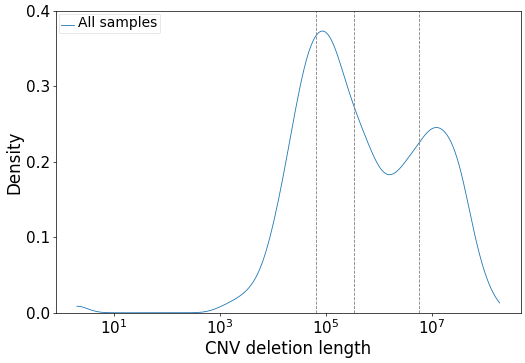

In [21]:
dataset = get_dataset('ovarian', 'cnv', 'del', ['NONRES', 'RES'], pos_class='RES')
plot_dataset = dataset.copy()
plot_dataset.loc[:, "CLASS_LABEL"] = 0

plt.rcParams['figure.dpi'] = 50
display(HTML("<style>table {whitespace: pre;}</style>"))
extractor = paper_ready_dbfe_plot(plot_dataset, dataset, "quantile", 4, ['All samples'], 
                                  'CNV deletion length', "quantile", RESULTS_FOLDER);

,dbfe_0_180274,dbfe_180274_1244133,dbfe_1244133_18048935,dbfe_18048935_inf,total_dbfe,frac_dbfe_0_180274,frac_dbfe_180274_1244133,frac_dbfe_1244133_18048935,frac_dbfe_18048935_inf,CLASS_LABEL
TCGA-36-1570,25,3,17,12,57,0.438596,0.052632,0.298246,0.210526,1
TCGA-36-1571,5,6,7,1,19,0.263158,0.315789,0.368421,0.052632,1
TCGA-36-1574,23,8,30,12,73,0.315068,0.109589,0.410959,0.164384,1
TCGA-61-2000,8,1,0,0,9,0.888889,0.111111,0.000000,0.000000,0
TCGA-61-2095,20,6,8,1,35,0.571429,0.171429,0.228571,0.028571,0


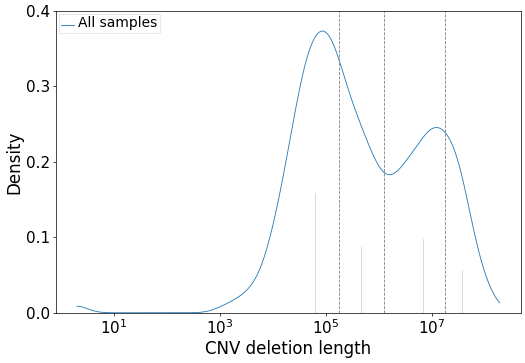

In [22]:
extractor = paper_ready_dbfe_plot(plot_dataset, dataset, "clustering", 4, ['All samples'],
                                  'CNV deletion length', "clustering", RESULTS_FOLDER);

,dbfe_0_40958,dbfe_40958_2171080,dbfe_2171080_79544511,dbfe_79544511_inf,total_dbfe,frac_dbfe_0_40958,frac_dbfe_40958_2171080,frac_dbfe_2171080_79544511,frac_dbfe_79544511_inf,CLASS_LABEL
TCGA-36-1570,16,12,28,1,57,0.280702,0.210526,0.491228,0.017544,1
TCGA-36-1571,0,13,5,1,19,0.000000,0.684211,0.263158,0.052632,1
TCGA-36-1574,12,21,40,0,73,0.164384,0.287671,0.547945,0.000000,1
TCGA-61-2000,1,8,0,0,9,0.111111,0.888889,0.000000,0.000000,0
TCGA-61-2095,13,16,6,0,35,0.371429,0.457143,0.171429,0.000000,0


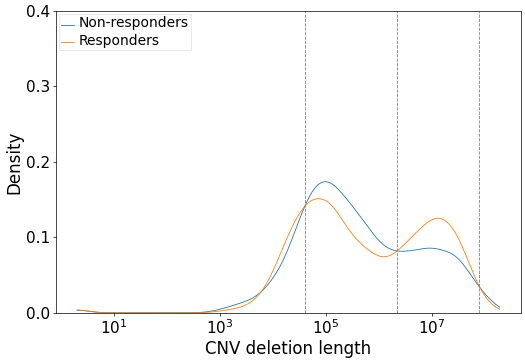

In [24]:
extractor = paper_ready_dbfe_plot(dataset, dataset, "supervised", 2, ['Non-responders', 'Responders'], 
                                  'CNV deletion length', "supervised", RESULTS_FOLDER);

## Sensitivity analysis

Here we analyze the sensitivity of the proposed feature extraction methods to different parameter values. Sensitivity will be evaluated based on the predictive performance of four different classifiers:
- Logistic Regression (LR)
- Naive Bayes (NB)
- Random Forest (RF)
- k-Nearest Neighbors (kNN)

We will experiment with four parameters:
1. Extracting counts, fractions, or both as features
2. The KDE bandwidth used in the KDE approach
3. The only peaks option in the KDE approach
4. CV-smoothing in the KDE approach
5. The max number of features produced by quantile binning and clustering

### Counts vs fractions

All the DBFE approaches can be used to produce features that are counts or fractions of variants of a given length. Here, we verify whether counts fractions, or the combination of both provide the best predictive capabilities.

In [8]:
param_sets = [
    {"include_counts": True, "include_fracs": False, "include_total": True}, 
    {"include_counts": False, "include_fracs": True, "include_total": True}, 
    {"include_counts": True, "include_fracs": True, "include_total": True}
]
bandwidth_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, METHODS, ALGORITHMS,
                                                                                    CV, "fracs_counts", param_sets,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    bandwidth_sensitivity = bandwidth_sensitivity.append(results_cancer_type)
    bandwidth_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'fracs_counts_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

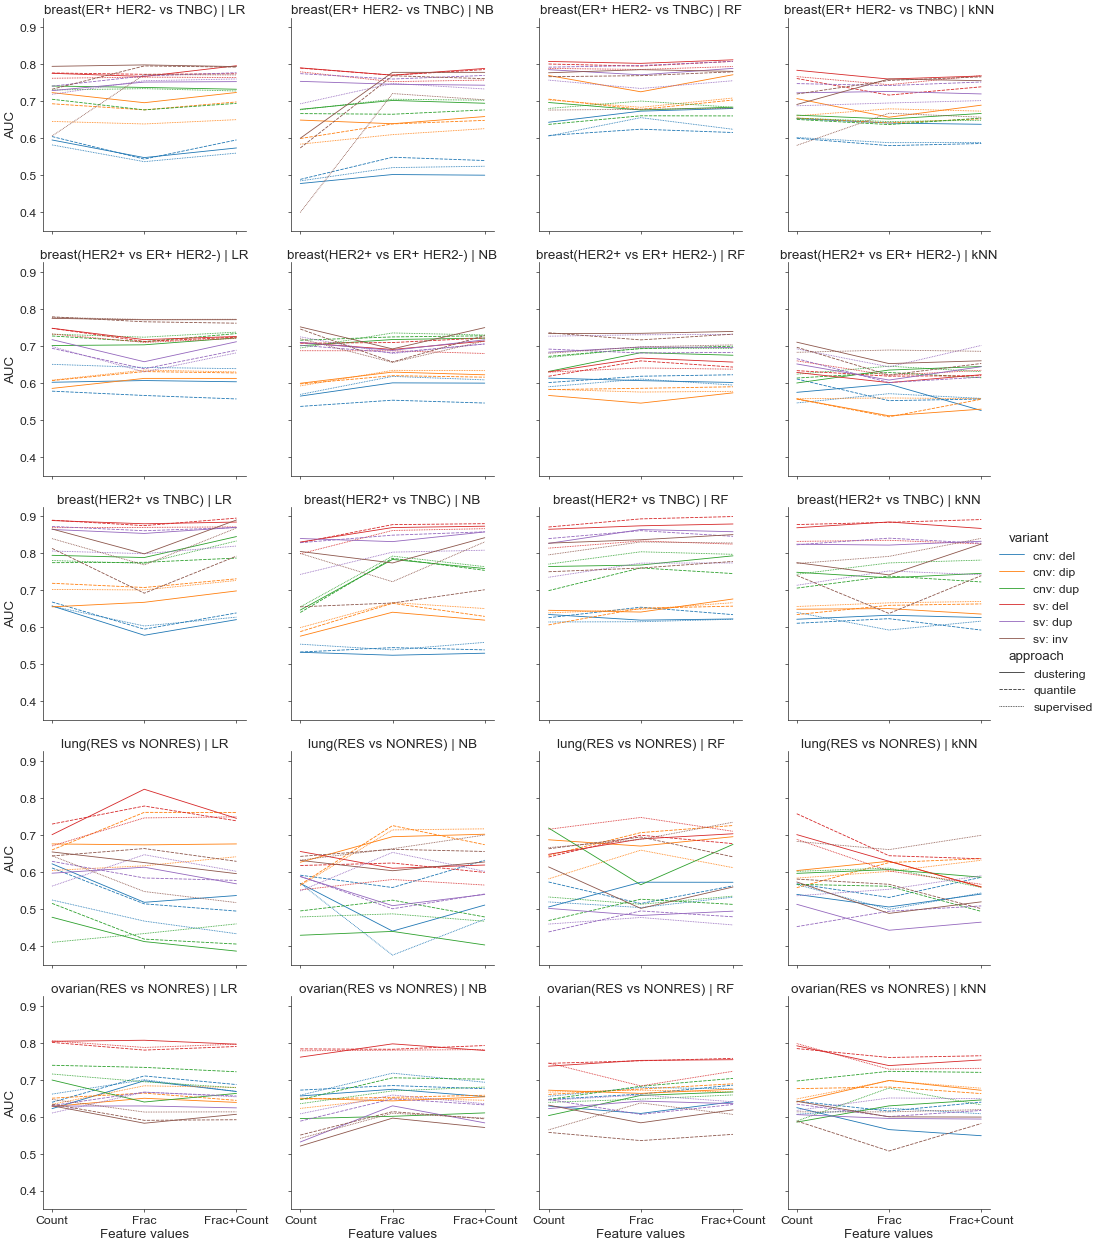

In [9]:
fracs_counts_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'fracs_counts_sensitivity.csv'), index_col=None)
fracs_counts_sensitivity_df.fracs_counts = fracs_counts_sensitivity_df.fracs_counts.map({
    "{'include_counts': True, 'include_fracs': False, 'include_total': True}": "Count", 
    "{'include_counts': False, 'include_fracs': True, 'include_total': True}": "Frac", 
    "{'include_counts': True, 'include_fracs': True, 'include_total': True}": "Frac+Count",
    "{'include_counts': True, 'include_fracs': False, 'include_total': True, 'n_bins': 'auto'}": "Count", 
    "{'include_counts': False, 'include_fracs': True, 'include_total': True, 'n_bins': 'auto'}": "Frac", 
    "{'include_counts': True, 'include_fracs': True, 'include_total': True, 'n_bins': 'auto'}": "Frac+Count"})
fracs_counts_sensitivity_df = fracs_counts_sensitivity_df.rename(columns={"fracs_counts": "Feature values"})
plot_sensitivity_results(fracs_counts_sensitivity_df, "Feature values", RESULTS_FOLDER, "fracs_counts")

As can be noticed on the above plot, using both fraction and counts together offers the best results. Depending on the dataset and variant type, using both counts and fractions either offers the best predictive performance or a good compromise between using only one of these representations. These results are confirmed by a series of Friedman and Nemenyi post-hoc tests.

In [10]:
calculate_param_tests(fracs_counts_sensitivity_df, "Feature values", "AUROC")

Approach:  quantile , Classifier:  RF
Count  mean value:  0.6642
Frac  mean value:  0.68
Frac+Count  mean value:  0.6838
Test p-value for AUROC: 0.0

Nemenyi post-hoc
               Count      Frac  Frac+Count
Count       1.000000  0.016151    0.001000
Frac        0.016151  1.000000    0.157722
Frac+Count  0.001000  0.157722    1.000000

Approach:  quantile , Classifier:  NB
Count  mean value:  0.645
Frac  mean value:  0.6719
Frac+Count  mean value:  0.6738
Test p-value for AUROC: 0.0

Nemenyi post-hoc
            Count      Frac  Frac+Count
Count       1.000  0.001000    0.001000
Frac        0.001  1.000000    0.559666
Frac+Count  0.001  0.559666    1.000000

Approach:  quantile , Classifier:  LR
Count  mean value:  0.6999
Frac  mean value:  0.6873
Frac+Count  mean value:  0.6942
Test p-value for AUROC: 0.0

Nemenyi post-hoc
               Count   Frac  Frac+Count
Count       1.000000  0.001    0.898296
Frac        0.001000  1.000    0.001000
Frac+Count  0.898296  0.001    1.000000

A

### KDE approach: bandwidth

For the supervised approach we also checked how the classifiers perform if the features are extracted from kernel density estimations with different bandwidth.

In [11]:
param_name = "bw"
param_values = np.linspace(0.05, 1.5, 30)
bandwidth_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    bandwidth_sensitivity = bandwidth_sensitivity.append(results_cancer_type)
    bandwidth_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

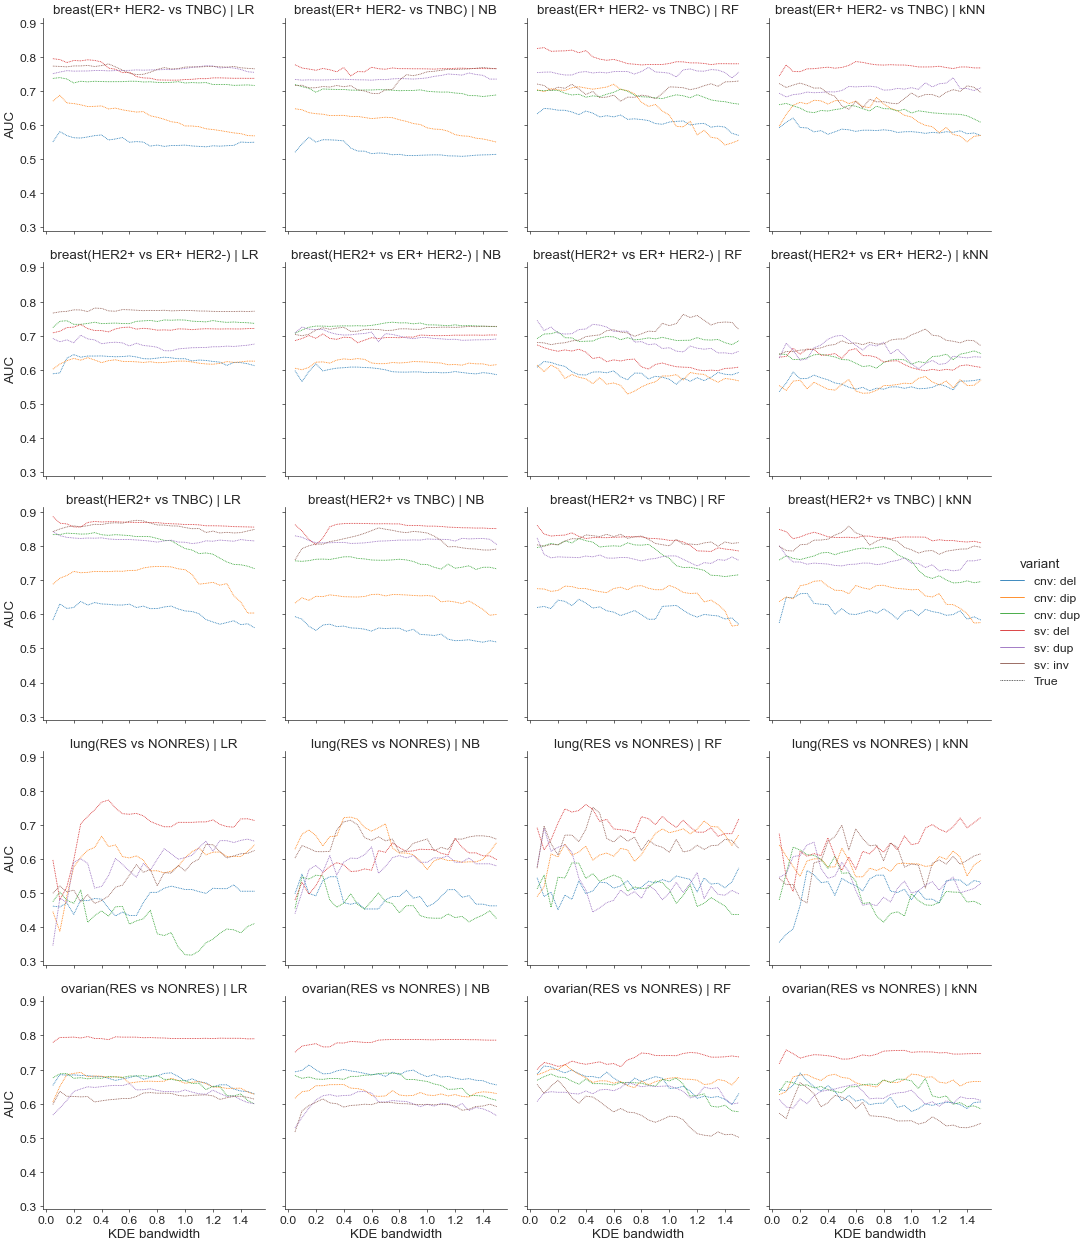

In [12]:
bandwidth_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index_col=None)
bandwidth_sensitivity_df = bandwidth_sensitivity_df.rename(columns={"bw": "KDE bandwidth"})
plot_sensitivity_results(bandwidth_sensitivity_df, "KDE bandwidth", RESULTS_FOLDER, "bw", style=True, dashes=[(1,1)])

As can be noticed on the plot above, bandwidth can have a significant impact on classifier performance. Depending on the dataset and variant type, classifier performance usually either slowly degrades with growing bandwidth or rapidly increases and stabilized. Therefore, the default value of KDE bandwidth was set to 0.5. However, for best performance KDE bandwidth in the supervised approach should be tuned for each dataset.

### KDE approach: only peaks

In [13]:
param_name = "only_peaks"
param_values = [True, False]
only_peaks_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    only_peaks_sensitivity = only_peaks_sensitivity.append(results_cancer_type)
    only_peaks_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

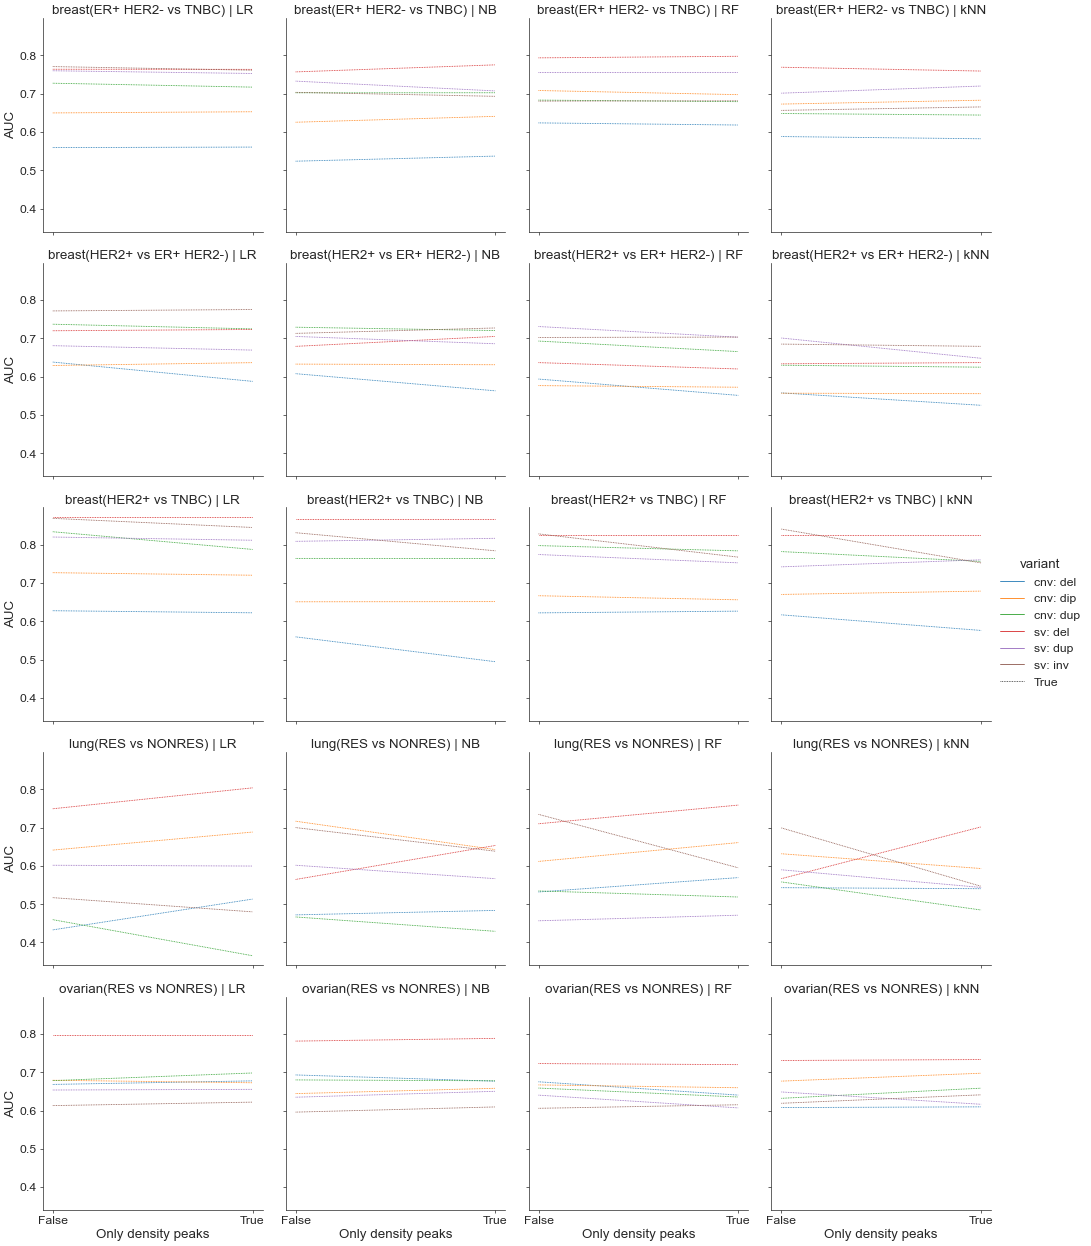

In [14]:
only_peaks_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index_col=None)
only_peaks_sensitivity_df.only_peaks = only_peaks_sensitivity_df.only_peaks.map({True: "True", False: "False"})
only_peaks_sensitivity_df = only_peaks_sensitivity_df.rename(columns={"only_peaks": "Only density peaks"})
plot_sensitivity_results(only_peaks_sensitivity_df, "Only density peaks", RESULTS_FOLDER, "only_peaks", style=True, dashes=[(1,1)])

In [15]:
calculate_param_tests(only_peaks_sensitivity_df, "Only density peaks", "AUROC", test=wilcoxon, post_hoc=False)

Approach:  supervised , Classifier:  RF
True  mean value:  0.6635
False  mean value:  0.6746
Test p-value for AUROC: 0.0001


Approach:  supervised , Classifier:  NB
True  mean value:  0.6646
False  mean value:  0.6714
Test p-value for AUROC: 0.1006


Approach:  supervised , Classifier:  LR
True  mean value:  0.6851
False  mean value:  0.6881
Test p-value for AUROC: 0.0523


Approach:  supervised , Classifier:  kNN
True  mean value:  0.648
False  mean value:  0.6593
Test p-value for AUROC: 0.1104




### KDE approach: cross-validation smoothing

In [16]:
param_name = "cv"
param_values = [None, 2, 3, 5, 7, 10]
cv_smoothing_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, ["supervised"], 
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    cv_smoothing_sensitivity = cv_smoothing_sensitivity.append(results_cancer_type)
    cv_smoothing_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

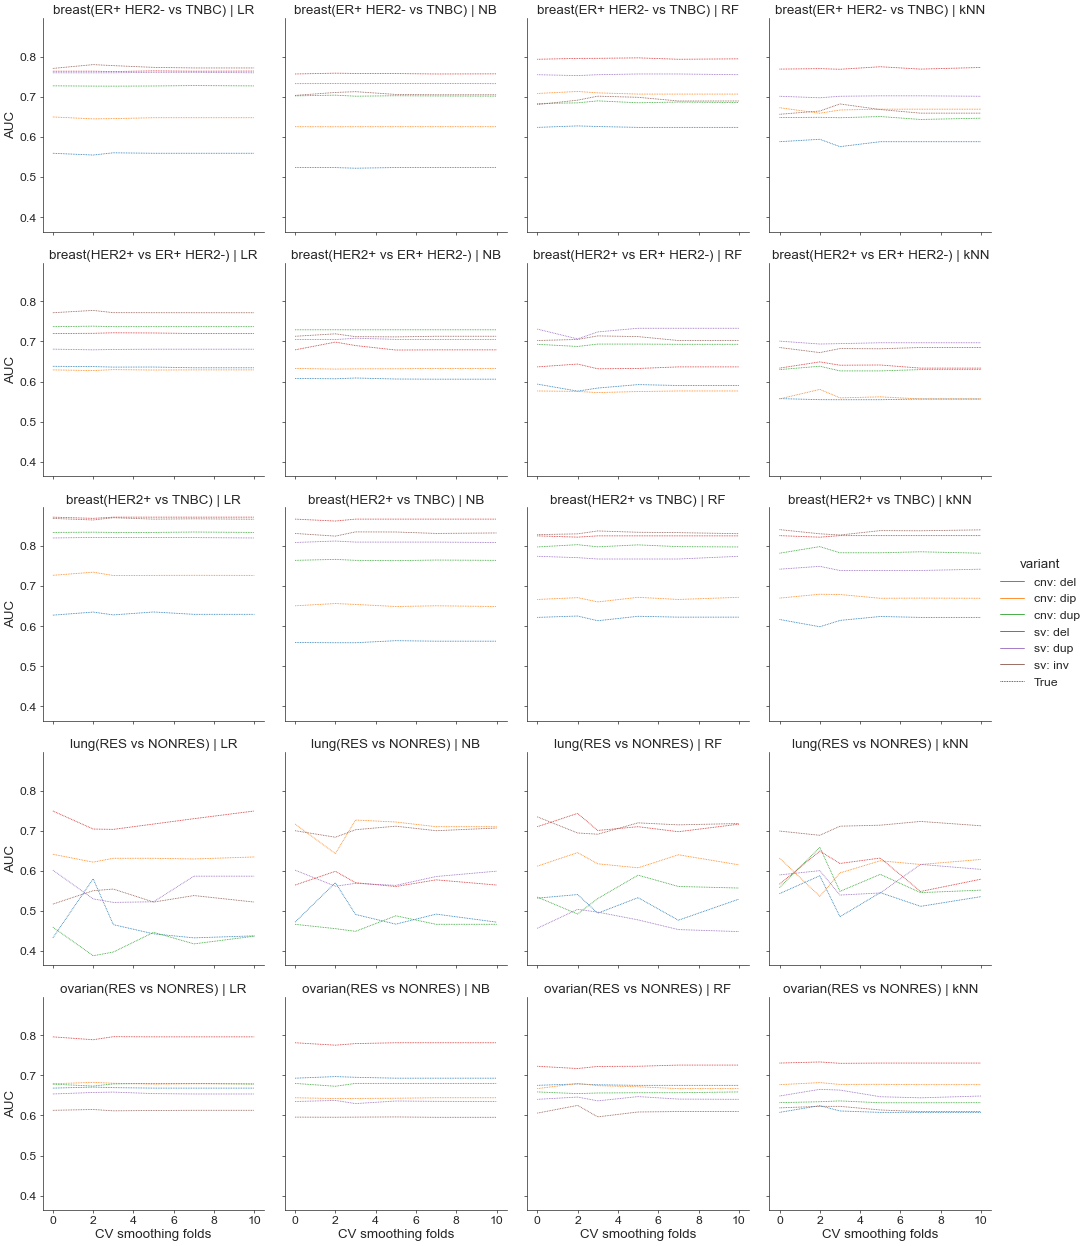

In [17]:
cv_smoothing_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index_col=None)
cv_smoothing_sensitivity_df.loc[cv_smoothing_sensitivity_df.cv == "None", "cv"] = "0"
cv_smoothing_sensitivity_df.loc[:, "cv"] = cv_smoothing_sensitivity_df.loc[:, "cv"].astype("int32")
cv_smoothing_sensitivity_df = cv_smoothing_sensitivity_df.rename(columns={"cv": "CV smoothing folds"})
plot_sensitivity_results(cv_smoothing_sensitivity_df, "CV smoothing folds", RESULTS_FOLDER, "cv", style=True, dashes=[(1,1)])

### Quantile and clustering: number of extracted features

The following set of experiments verifies the sensitivity of the proposed feature extraction methods to changing the number of produced features. In quantile binning, the effect of the number of quantiles was inspected. In the clustering approach, the impact of the number of clusters was measured.

In [18]:
param_name = "n_bins"
param_values = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20, 25, 30, 35, 40, 50]
n_bins_sensitivity = pd.DataFrame()

for cancer in tqdm(CANCERS):
    results_cancer_type = Parallel(n_jobs=7)(delayed(multimethod_sensitivity_tests)(cancer, variant, 
                                                                                    ["quantile", "clustering"],
                                                                                    ALGORITHMS, CV, 
                                                                                    param_name, param_values,
                                                                                    HOLDOUT_SIZE)
                                             for variant in VARIANTS)
    n_bins_sensitivity = n_bins_sensitivity.append(results_cancer_type)
    n_bins_sensitivity.to_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

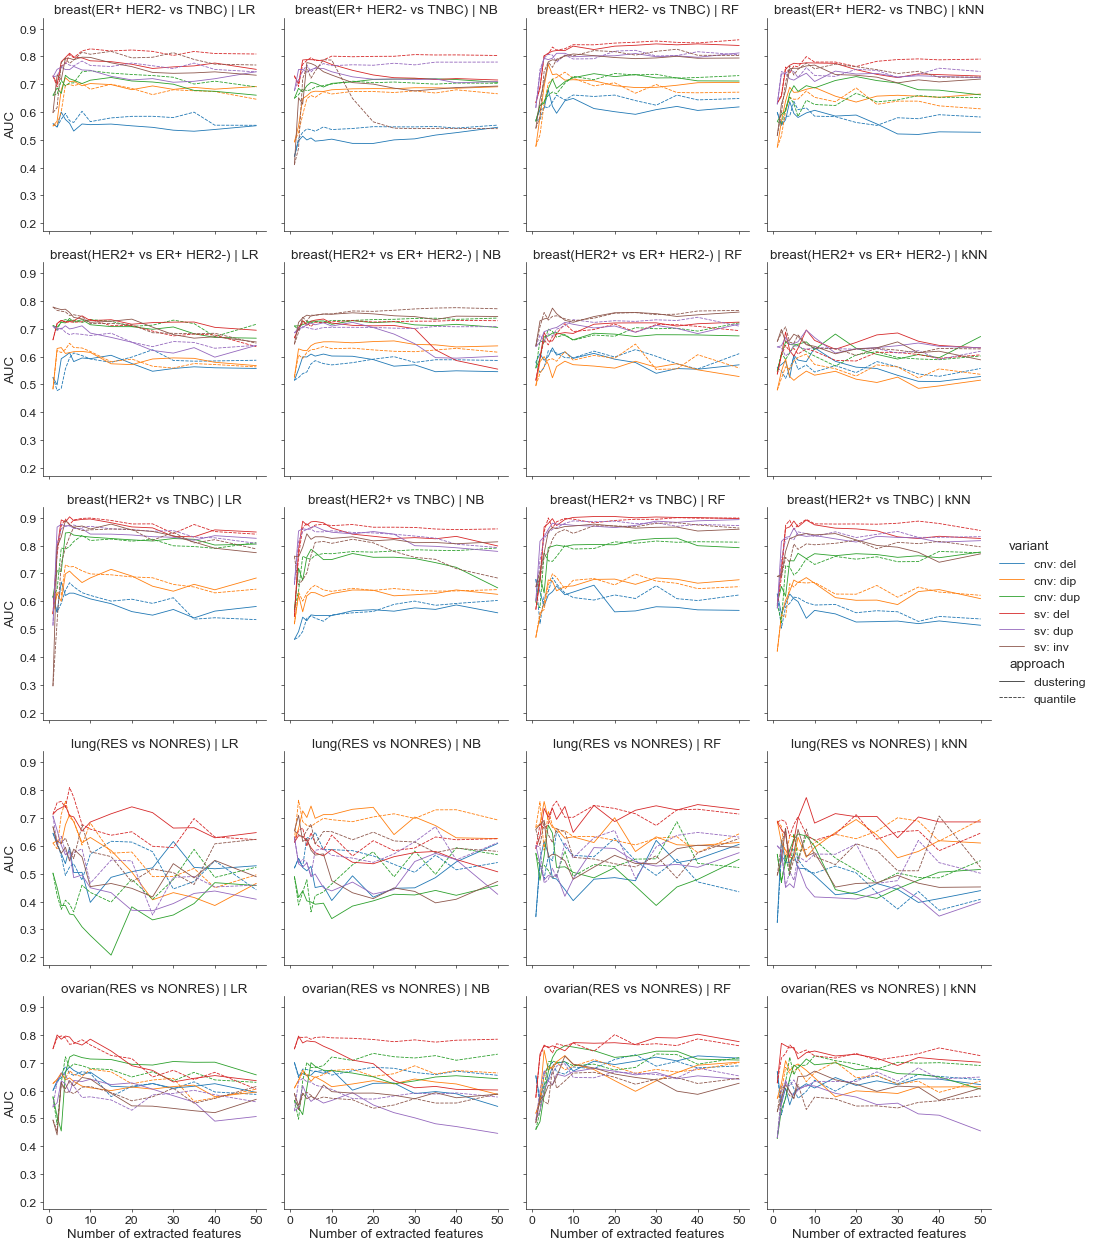

In [19]:
n_bins_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index_col=None)
n_bins_sensitivity_df = n_bins_sensitivity_df.rename(columns={"n_bins": "Number of extracted features"})
plot_sensitivity_results(n_bins_sensitivity_df, "Number of extracted features", RESULTS_FOLDER, "n_bins")

## Comparative evaluation on training and testing data

To evaluate the predictive performance of DBFE, we combined features of each variant type within a given approach. The parameters for each approach were chosen base on the sensitivity tests for each dataset. Moreover, we compared DBFE to PAM50 gene amplifications. As a result, for each dataset we compared the performance of the:

- quantile binning approach (sv+cnv)
- clustering approach (sv+cnv)
- supervised approach (sv+cnv)
- PAM50 amplifications (geneamps)
- quantile+PAM50 (sv+cnv+geneamps)
- clustering+PAM50 (sv+cnv+geneamps)
- supervised+PAM50 (sv+cnv+geneamps)


In [20]:
# Retrieving best parameters from sensitivity tests
n_bins_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'n_bins_sensitivity.csv'), index_col=None)
best_n_bins = get_best_cv_param(n_bins_sensitivity_df, "n_bins")

cv_smoothing_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'cv_smoothing_sensitivity.csv'), index_col=None)
best_cv = get_best_cv_param(cv_smoothing_sensitivity_df, "cv")
best_cv = best_cv.fillna("None")

only_peaks_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'only_peaks_sensitivity.csv'), index_col=None)
best_only_peaks = get_best_cv_param(only_peaks_sensitivity_df, "only_peaks")

bandwidth_sensitivity_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'bandwidth_sensitivity.csv'), index_col=None)
best_bw = get_best_cv_param(bandwidth_sensitivity_df, "bw")

def best_params_dict(breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm):
    if breakpoint_type == "supervised":
        result = { 
            "n_bins": "auto",
            "only_peaks": best_param_value(best_only_peaks, "only_peaks", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
            "bw": best_param_value(best_bw, "bw", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
            "cv": best_param_value(best_cv, "cv", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm),
        }
        
        if result["cv"] != "None":
            result["cv"] = int(result["cv"])
        else:
            result["cv"] = None
            
        return result
    else:
        return {  
            "n_bins": int(best_param_value(best_n_bins, "n_bins", breakpoint_type, cancer_type, class_labels, variant_group, variant_type, algorithm)),
        } 

### Holdout results

In [21]:
multivariant_holdout_results = pd.DataFrame()

results_cancer_type = Parallel(n_jobs=5)(delayed(multivariant_holdout_tests) (cancer, VARIANTS, ["quantile", "clustering", "supervised"],
                                                                              ALGORITHMS, best_params_dict)
                                         for cancer in CANCERS)
multivariant_holdout_results = multivariant_holdout_results.append(results_cancer_type)
multivariant_holdout_results.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results.csv'), index=False)

In [22]:
multivariant_holdout_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results.csv'), index_col=None)
results_df = multivariant_holdout_results_df
cancer_type_cat = pd.CategoricalDtype(categories=["ovarian", "lung", "breast"], ordered=True)
results_df.cancer_type = results_df.cancer_type.astype(cancer_type_cat)
classes_cat = pd.CategoricalDtype(categories=["RES vs NONRES", "HER2+ vs ER+ HER2-", "HER2+ vs TNBC", "ER+ HER2- vs TNBC"], ordered=True)
results_df.classes = results_df.classes.astype(classes_cat)
breakpoint_cat = pd.CategoricalDtype(categories=["quantile", "clustering", "supervised", "PAM50"], ordered=True)
results_df.breakpoint_type = results_df.breakpoint_type.astype(breakpoint_cat)
group_cat = pd.CategoricalDtype(categories=["sv+cnv", "geneamps", "sv+cnv+geneamps"], ordered=True)
results_df.variant_group = results_df.variant_group.astype(group_cat)

results_df = multivariant_holdout_results_df.groupby(["cancer_type", "classes", "algorithm", "variant_group", "breakpoint_type"]).mean().loc[:, ["AUROC", "features"]].round(3).reset_index()
results_df.loc[results_df.variant_group == "geneamps", "breakpoint_type"] = "PAM50"
results_df = results_df.drop_duplicates()
results_df = results_df.dropna()
results_pivot_df = results_df.pivot(index=["algorithm", "cancer_type", "classes"], columns=["variant_group", "breakpoint_type"], values=["AUROC"])
results_pivot_df.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_results_formatted.csv'))
results_pivot_df

AUROC                        \
variant_group                              sv+cnv                         
breakpoint_type                          quantile clustering supervised   
algorithm cancer_type classes                                             
LR        ovarian     RES vs NONRES         0.649      0.657      0.665   
          lung        RES vs NONRES         0.425      0.212      0.462   
          breast      HER2+ vs ER+ HER2-    0.920      0.948      0.953   
                      HER2+ vs TNBC         0.919      0.879      0.941   
                      ER+ HER2- vs TNBC     0.894      0.918      0.921   
NB        ovarian     RES vs NONRES         0.644      0.659      0.743   
          lung        RES vs NONRES         0.450      0.562      0.425   
          breast      HER2+ vs ER+ HER2-    0.913      0.899      0.934   
                      HER2+ vs TNBC         0.866      0.889      0.928   
                      ER+ HER2- vs TNBC     0.592      0.740      0.857   
RF        ovarian     RES vs NONRES         0.742      0.726      0.693   
          lung        RES vs NONRES         0.588      0.512      0.525   
          breast      HER2+ vs ER+ HER2-    0.956      0.950      0.934   
                      HER2+ vs TNBC         0.950      0.948      0.949   
                      ER+ HER2- vs TNBC     0.910      0.914      0.904   
kNN       ovarian     RES vs NONRES         0.706      0.750      0.725   
          lung        RES vs NONRES         0.550      0.650      0.400   
          breast      HER2+ vs ER+ HER2-    0.888      0.899      0.900   
                      HER2+ vs TNBC         0.915      0.916      0.935   
                      ER+ HER2- vs TNBC     0.812      0.847      0.877   

                                                                              \
variant_group                            geneamps sv+cnv+geneamps              
breakpoint_type                             PAM50        quantile clustering   
algorithm cancer_type classes                                                  
LR        ovarian     RES vs NONRES         0.611           0.656      0.640   
          lung        RES vs NONRES         0.288           0.375      0.337   
          breast      HER2+ vs ER+ HER2-    0.929           0.977      0.980   
                      HER2+ vs TNBC         0.976           0.967      0.936   
                      ER+ HER2- vs TNBC     0.867           0.933      0.940   
NB        ovarian     RES vs NONRES         0.536           0.630      0.681   
          lung        RES vs NONRES         0.525           0.562      0.587   
          breast      HER2+ vs ER+ HER2-    0.985           0.968      0.955   
                      HER2+ vs TNBC         0.964           0.888      0.944   
                      ER+ HER2- vs TNBC     0.793           0.639      0.750   
RF        ovarian     RES vs NONRES         0.588           0.758      0.726   
          lung        RES vs NONRES         0.450           0.538      0.406   
          breast      HER2+ vs ER+ HER2-    1.000           0.997      0.996   
                      HER2+ vs TNBC         0.995           0.996      0.994   
                      ER+ HER2- vs TNBC     0.905           0.938      0.949   
kNN       ovarian     RES vs NONRES         0.532           0.718      0.750   
          lung        RES vs NONRES         0.575           0.425      0.569   
          breast      HER2+ vs ER+ HER2-    0.875           0.931      0.944   
                      HER2+ vs TNBC         0.865           0.965      0.936   
                      ER+ HER2- vs TNBC     0.815           0.851      0.903   

                                                     
variant_group                                        
breakpoint_type                          supervised  
algorithm cancer_type classes                        
LR        ovarian     RES vs NONRES           0.610  
          lung        RES vs NONRES           0.362 

Below we additionally present the number of features used by each approach.

In [23]:
features_pivot_df = results_df.pivot(index=["algorithm", "cancer_type", "classes"], columns=["variant_group", "breakpoint_type"], values=["features"])
features_pivot_df = features_pivot_df.astype("int")
features_pivot_df.to_csv(os.path.join(RESULTS_FOLDER, 'multivariant_holdout_features_formatted.csv'))
features_pivot_df

features                        \
variant_group                              sv+cnv                         
breakpoint_type                          quantile clustering supervised   
algorithm cancer_type classes                                             
LR        ovarian     RES vs NONRES           136        138         58   
          lung        RES vs NONRES            76        152         90   
          breast      HER2+ vs ER+ HER2-      174        110         44   
                      HER2+ vs TNBC           144        148         50   
                      ER+ HER2- vs TNBC       272        184         78   
NB        ovarian     RES vs NONRES           100         84         50   
          lung        RES vs NONRES            54         86         96   
          breast      HER2+ vs ER+ HER2-      154        170         46   
                      HER2+ vs TNBC           168        148         46   
                      ER+ HER2- vs TNBC       322        208         48   
RF        ovarian     RES vs NONRES           282        136         64   
          lung        RES vs NONRES            36         24        140   
          breast      HER2+ vs ER+ HER2-      252        228         78   
                      HER2+ vs TNBC           168        218         48   
                      ER+ HER2- vs TNBC       272        178         50   
kNN       ovarian     RES vs NONRES           146        176         44   
          lung        RES vs NONRES            40        118         70   
          breast      HER2+ vs ER+ HER2-       88         66         42   
                      HER2+ vs TNBC           258        124         46   
                      ER+ HER2- vs TNBC       244        274         54   

                                                                              \
variant_group                            geneamps sv+cnv+geneamps              
breakpoint_type                             PAM50        quantile clustering   
algorithm cancer_type classes                                                  
LR        ovarian     RES vs NONRES            50             186        188   
          lung        RES vs NONRES            50             126        202   
          breast      HER2+ vs ER+ HER2-       50             224        160   
                      HER2+ vs TNBC            50             194        198   
                      ER+ HER2- vs TNBC        50             322        234   
NB        ovarian     RES vs NONRES            50             150        134   
          lung        RES vs NONRES            50             104        136   
          breast      HER2+ vs ER+ HER2-       50             204        220   
                      HER2+ vs TNBC            50             218        198   
                      ER+ HER2- vs TNBC        50             372        258   
RF        ovarian     RES vs NONRES            50             332        186   
          lung        RES vs NONRES            50              86         74   
          breast      HER2+ vs ER+ HER2-       50             302        278   
                      HER2+ vs TNBC            50             218        268   
                      ER+ HER2- vs TNBC        50             322        228   
kNN       ovarian     RES vs NONRES            50             196        226   
          lung        RES vs NONRES            50              90        168   
          breast      HER2+ vs ER+ HER2-       50             138        116   
                      HER2+ vs TNBC            50             308        174   
                      ER+ HER2- vs TNBC        50             294        324   

                                                     
variant_group                                        
breakpoint_type                          supervised  
algorithm cancer_type classes                        
LR        ovarian     RES vs NONRES             108  
          lung        RES vs NONRES             1

### Features designed by a human expert

Below is the list of features designed by a human expert for ovarian cancer data and the corresponding holdout results.

In [24]:
EXPERT_VARIANTS = [('cnv', 'del', [(0, 30), (30, 3500), (3500, 100000), (100000, np.inf)]), 
                   ('cnv', 'dip', [(0, 30), (30, 500), (500, 100000), (100000, np.inf)]),
                   ('cnv', 'dup', [(0, 30), (30, 100), (100, 350), (350, 3000), (3000, 25000), (25000, np.inf)]),
                   ('sv', 'del', [(0, 30), (30, 3500), (3500, 100000), (100000, np.inf)]), 
                   ('sv', 'dup', [(0, 30), (30, 100), (100, 1000), (1000, 30000), (30000, np.inf)])]

In [25]:
human_expert_results = human_expert_tests(('ovarian', ['RES', 'NONRES']), EXPERT_VARIANTS, ALGORITHMS)
human_expert_results.to_csv(os.path.join(RESULTS_FOLDER, 'human_expert_results.csv'), index=False)

In [26]:
human_expert_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'human_expert_results.csv'), index_col=None)
human_expert_results_df.round(3)

,Accuracy,Precision,Recall,F1,AUROC,Kappa,MCC,Balanced accuracy,algorithm,features,cancer_type,classes,pos_class,variant_group,variant_type,breakpoint_type
0,0.697,0.708,0.567,0.630,0.716,0.379,0.385,0.686,RF,23,ovarian,RES vs NONRES,RES,expert,NaN,expert
1,0.591,0.560,0.467,0.509,0.595,0.163,0.165,0.581,NB,23,ovarian,RES vs NONRES,RES,expert,NaN,expert
2,0.742,0.783,0.600,0.679,0.757,0.470,0.482,0.731,LR,23,ovarian,RES vs NONRES,RES,expert,NaN,expert
3,0.636,0.607,0.567,0.586,0.641,0.263,0.263,0.631,kNN,23,ovarian,RES vs NONRES,RES,expert,NaN,expert


## Feature importance comparison

We also analyzed how DBFE feature fare against gene amplifications in terms of feature importance by calculating the ANOVA F-test. FOr each dataset, we show the top 10 most important features.

In [27]:
feature_importance_results = pd.DataFrame()

results_cancer_type = Parallel(n_jobs=5)(delayed(feature_importance_tests) (cancer, VARIANTS, ["quantile", "clustering", "supervised"],
                                                                              ALGORITHMS, best_params_dict)
                                         for cancer in CANCERS)
feature_importance_results = feature_importance_results.append(results_cancer_type)
feature_importance_results.to_csv(os.path.join(RESULTS_FOLDER, 'feature_importance_results.csv'), index=False)

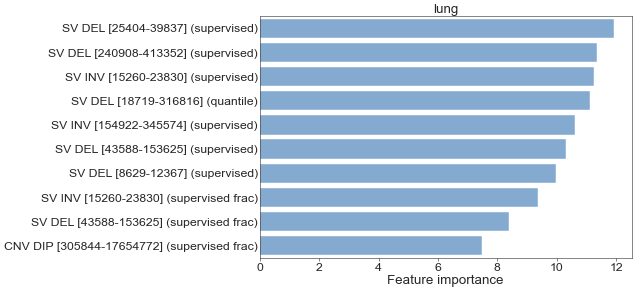

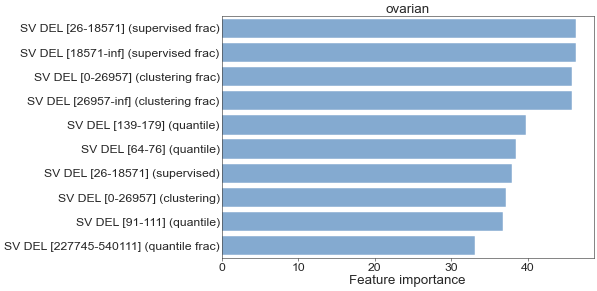

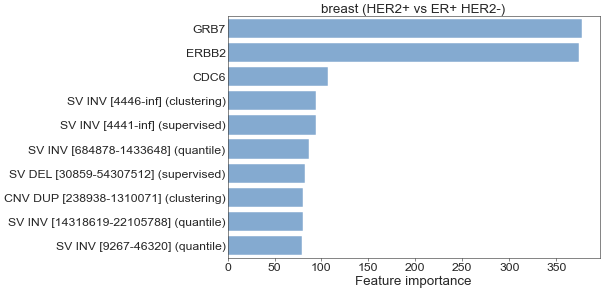

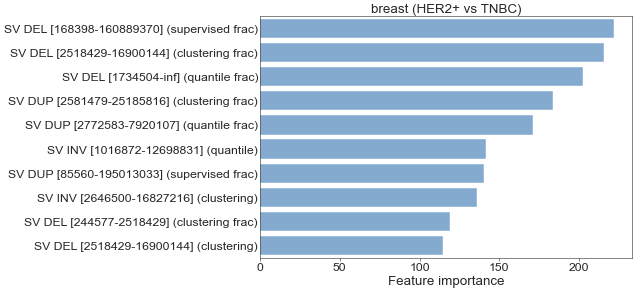

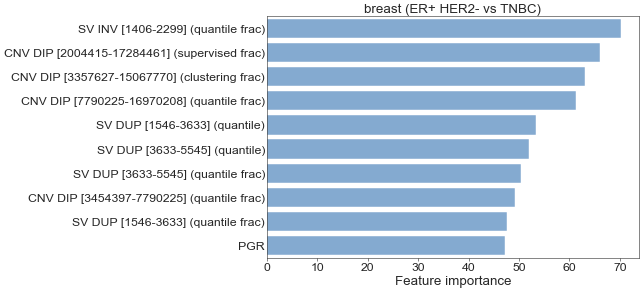

In [28]:
feature_importance_results_df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'feature_importance_results.csv'), index_col=None)
plt.rcParams['figure.dpi'] = 40

for cancer in CANCERS:
    allowed_classes, cancer_type, class_labels, pos_class, _, __ = extract_cancer_varaint(cancer, (None, None))
    plot_name = cancer_type + "_" + class_labels.replace(" ", "_")
    
    plot_feature_importance(feature_importance_results_df, cancer_type, class_labels, plot_name, RESULTS_FOLDER)

## Clustering

Since the quantile binning and clustering approaches can generate features without class labels, we verified if these approaches can be used to perform interpretable cluster analyses. For this purpose we used the breast cancer dataset, which consists of 811 samples and would be the most difficult to analyze manually.

### Quantile binning approach

First we generated four quantile bins for each variant type and pro-duced a total of 54 DBFE features (6 variant types x (4 count features + 4 fraction features + 1 total count)). Based on these features, we created a 2D plot using UMAP dimensionality reduction .

In [8]:
breast_quantile_df = get_breast_clustering_data("quantile", VARIANTS, 4, SEED)
breast_quantile_df.to_csv(os.path.join(RESULTS_FOLDER, "Clusters_quantile.csv"))

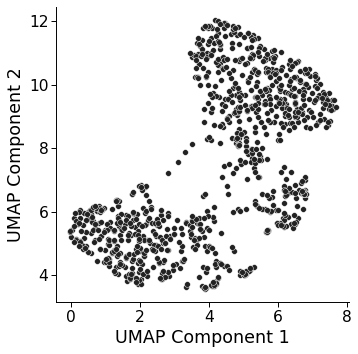

In [9]:
breast_quantile_df = pd.read_csv(os.path.join(RESULTS_FOLDER, "Clusters_quantile.csv"), index_col=0)
plt.rcParams['figure.dpi'] = 70
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_umap")

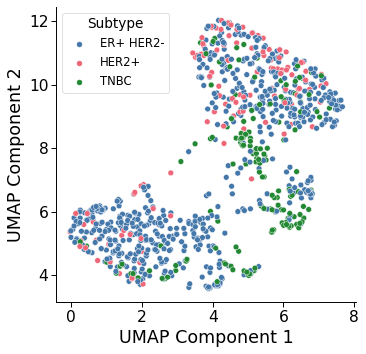

In [10]:
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_subtype", hue="Subtype", palette=SUBTYPE_COLORS)

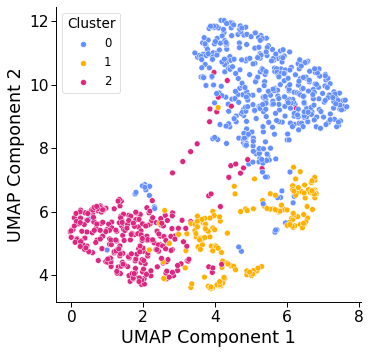

In [11]:
plot_clusters(breast_quantile_df, RESULTS_FOLDER, "quantile_clusters", hue="Cluster", palette=CLUSTER_COLORS)

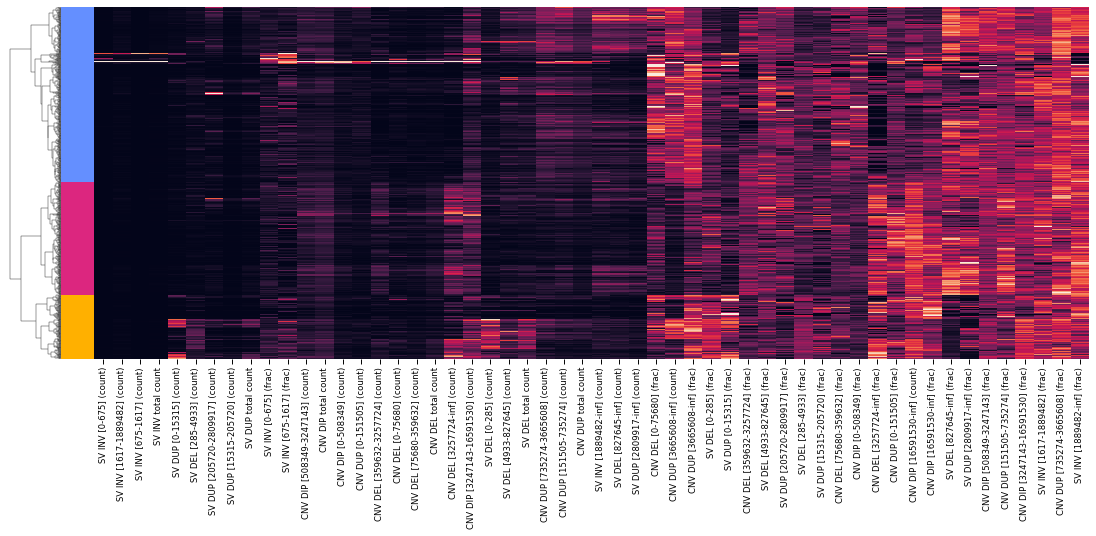

In [12]:
create_clustergram(breast_quantile_df, RESULTS_FOLDER, "quantile_clustergram", COLOR_MAPPING)

### Clustering approach

The same analysis was performed using the clustering approach, yielding similar results.

In [13]:
breast_clustering_df = get_breast_clustering_data("clustering", VARIANTS, 4, SEED)
breast_clustering_df.to_csv(os.path.join(RESULTS_FOLDER, "Clusters_clustering.csv"))

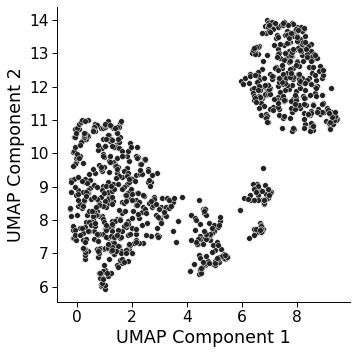

In [14]:
breast_clustering_df = pd.read_csv(os.path.join(RESULTS_FOLDER, "Clusters_clustering.csv"), index_col=0)
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_umap")

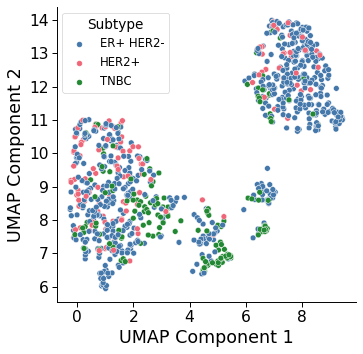

In [15]:
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_subtype", hue="Subtype", palette=SUBTYPE_COLORS)

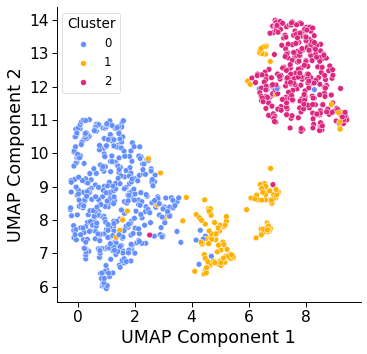

In [16]:
plot_clusters(breast_clustering_df, RESULTS_FOLDER, "clustering_clusters", hue="Cluster", palette=CLUSTER_COLORS)

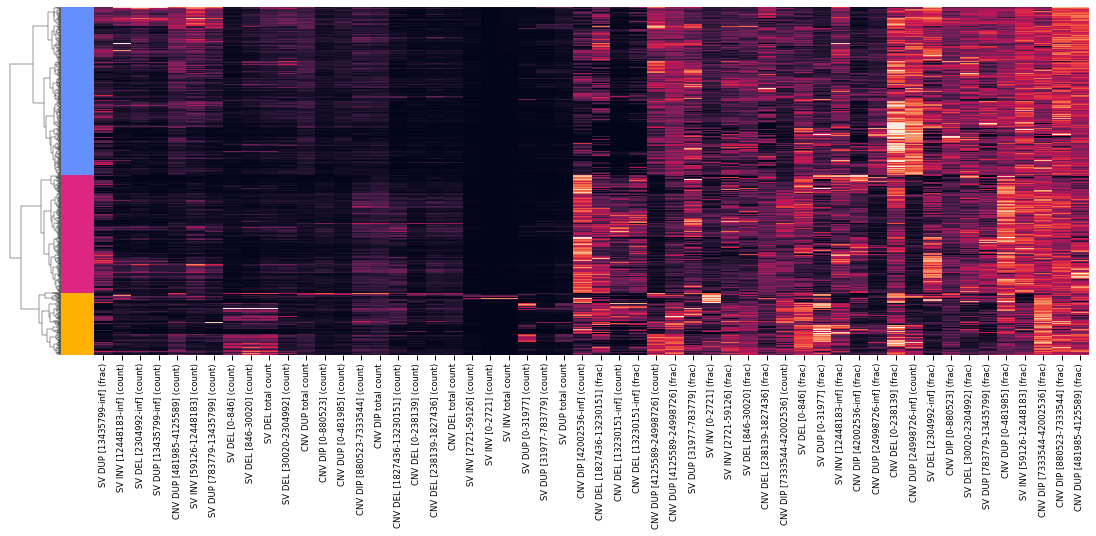

In [17]:
create_clustergram(breast_clustering_df, RESULTS_FOLDER, "clustering_clustergram", COLOR_MAPPING)